# Downloading Spark

In [ ]:
!apt-get update
# Download Java Virtual Machine (JVM)
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 https://cli.github.com/packages stable InRelease [3,917 B]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,006 kB]
Get:9 https://cli.github.com/packages stable/main amd64 Packages [346 B]
Get:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:11 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:12 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Get:13 https://r2u.stat.illinois.edu/ubuntu jammy/main a

Mounting drive to access the drive files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Unzip the file
!tar xf /content/drive/MyDrive/spark/spark-3.5.1-bin-hadoop3.tgz
!pip install -q findspark

In [ ]:
# set your spark folder to your system path environment.
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.1-bin-hadoop3"

In [ ]:
!ls

drive  sample_data  spark-3.5.1-bin-hadoop3


Initiate spark

In [ ]:
import findspark
findspark.init()
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from PIL import Image
import numpy as np
import io

spark = SparkSession.builder \
    .appName("FireImageClassification") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .config("spark.memory.fraction", "0.8") \
    .config("spark.sql.adaptive.enabled", "true") \
    .getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)
sc = spark.sparkContext

Saving images into spark RDD

In [ ]:
def load_image_data(file_path):
    try:
        # Read image
        img = Image.open(file_path)
        # Convert to RGB if not already
        if img.mode != 'RGB':
            img = img.convert('RGB')
        # Resize to manageable size
        img = img.resize((128, 128))
        # Convert to numpy array
        img_array = np.array(img)
        # Flatten the array
        flattened = img_array.flatten()

        return (file_path, flattened.tolist(), img_array.shape)
    except Exception as e:
        return (file_path, None, str(e))

# Get list of image files
fire_path = "/content/drive/MyDrive/bdf_Dataset/fire_dataset/fire_images"
non_fire_path = "/content/drive/MyDrive/bdf_Dataset/fire_dataset/non_fire_images"

# Get all image files
fire_files = []
non_fire_files = []

for root, dirs, files in os.walk(fire_path):
    for file in files:
        if file.lower().endswith('.png'):
            fire_files.append(os.path.join(root, file))

for root, dirs, files in os.walk(non_fire_path):
    for file in files:
        if file.lower().endswith('.png'):
            non_fire_files.append(os.path.join(root, file))

print(f"Found {len(fire_files)} fire images")
print(f"Found {len(non_fire_files)} non-fire images")

# Create RDDs with explicit label assignment
def process_images_with_explicit_labels(file_list, label_value, batch_size=100):
    results = []
    for i in range(0, len(file_list), batch_size):
        batch = file_list[i:i+batch_size]
        batch_rdd = sc.parallelize(batch)
        # Process image and explicitly add the label
        processed = batch_rdd.map(lambda x: (x, *load_image_data(x)[1:], label_value))
        results.append(processed)
    return results

# Process images with explicit labels
fire_batches = process_images_with_explicit_labels(fire_files, 1)  # Label 1 for fire
non_fire_batches = process_images_with_explicit_labels(non_fire_files, 0)  # Label 0 for non-fire

# Combine all batches
all_images_rdd = sc.union([batch for batch in fire_batches + non_fire_batches])

# Filter out failed image loads
successful_images_rdd = all_images_rdd.filter(lambda x: x[1] is not None)

print(f"Total images processed: {all_images_rdd.count()}")
print(f"Successful images: {successful_images_rdd.count()}")

# Show some sample data
print("Sample images from RDD:")
samples = successful_images_rdd.take(5)
for sample in samples:
    print(f"Path: {sample[0]}, Features length: {len(sample[1])}, Shape: {sample[2]}, Label: {sample[3]}")

# Convert to DataFrame
schema = StructType([
    StructField("path", StringType(), True),
    StructField("features", ArrayType(IntegerType()), True),
    StructField("shape", StringType(), True),
    StructField("label", IntegerType(), True)
])

image_df = successful_images_rdd.toDF(schema)

# Show DataFrame sample
print("DataFrame sample:")
image_df.select("path", "label").show(10, truncate=False)

# Check class distribution
print("Class distribution:")
image_df.groupBy("label").count().show()

# Verify we have both classes
fire_count = image_df.filter(col("label") == 1).count()
non_fire_count = image_df.filter(col("label") == 0).count()

print(f"Fire images (label 1): {fire_count}")
print(f"Non-fire images (label 0): {non_fire_count}")


Found 100 fire images
Found 100 non-fire images
Total images processed: 200
Successful images: 200
Sample images from RDD:
Path: /content/drive/MyDrive/bdf_Dataset/fire_dataset/fire_images/fire.13.png, Features length: 49152, Shape: (128, 128, 3), Label: 1
Path: /content/drive/MyDrive/bdf_Dataset/fire_dataset/fire_images/fire.1.png, Features length: 49152, Shape: (128, 128, 3), Label: 1
Path: /content/drive/MyDrive/bdf_Dataset/fire_dataset/fire_images/fire.12.png, Features length: 49152, Shape: (128, 128, 3), Label: 1
Path: /content/drive/MyDrive/bdf_Dataset/fire_dataset/fire_images/fire.100.png, Features length: 49152, Shape: (128, 128, 3), Label: 1
Path: /content/drive/MyDrive/bdf_Dataset/fire_dataset/fire_images/fire.11.png, Features length: 49152, Shape: (128, 128, 3), Label: 1
DataFrame sample:
+------------------------------------------------------------------------+-----+
|path                                                                    |label|
+--------------------------

In [ ]:
# Prepare for ML training
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf

# Convert array to dense vector
def array_to_vector(arr):
    return Vectors.dense(arr)

# Register UDF to convert array to vector
array_to_vector_udf = udf(array_to_vector, VectorUDT())

# Convert the features array to vector
image_df = image_df.withColumn("features_vector", array_to_vector_udf(col("features")))

# Show the updated schema
print("Updated DataFrame schema:")
image_df.printSchema()

# Create VectorAssembler (though we already have the vector, this is for consistency)
vector_assembler = VectorAssembler(inputCols=["features_vector"], outputCol="feature_vector")

# Create classifier
rf = RandomForestClassifier(
    featuresCol="feature_vector",
    labelCol="label",
    numTrees=30,  # Reduced for faster training
    maxDepth=8,   # Reduced for faster training
    seed=42
)

# Create pipeline
pipeline = Pipeline(stages=[vector_assembler, rf])

# Split data
train_df, test_df = image_df.randomSplit([0.8, 0.2], seed=42)

print(f"Training samples: {train_df.count()}")
print(f"Test samples: {test_df.count()}")

# Check if we have both classes in training data
print("Training class distribution:")
train_df.groupBy("label").count().show()

# Train model
print("Training Random Forest model...")
model = pipeline.fit(train_df)

# Make predictions
predictions = model.transform(test_df)

# Evaluate model
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="accuracy"
)
accuracy = evaluator.evaluate(predictions)
print(f"Model Accuracy: {accuracy:.4f}")

# Show predictions
print("Sample predictions:")
predictions.select("path", "label", "prediction").show(10, truncate=False)

# Confusion matrix
print("Confusion Matrix:")
predictions.groupBy("label", "prediction").count().show()

# Alternative: Try Logistic Regression (often works better with high-dimensional data

Updated DataFrame schema:
root
 |-- path: string (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: integer (containsNull = true)
 |-- shape: string (nullable = true)
 |-- label: integer (nullable = true)
 |-- features_vector: vector (nullable = true)

Training samples: 155
Test samples: 45
Training class distribution:
+-----+-----+
|label|count|
+-----+-----+
|    1|   77|
|    0|   78|
+-----+-----+

Training Random Forest model...
Model Accuracy: 0.8000
Sample predictions:
+------------------------------------------------------------------------+-----+----------+
|path                                                                    |label|prediction|
+------------------------------------------------------------------------+-----+----------+
|/content/drive/MyDrive/bdf_Dataset/fire_dataset/fire_images/fire.100.png|1    |1.0       |
|/content/drive/MyDrive/bdf_Dataset/fire_dataset/fire_images/fire.14.png |1    |1.0       |
|/content/drive/MyDrive/bdf_Datase

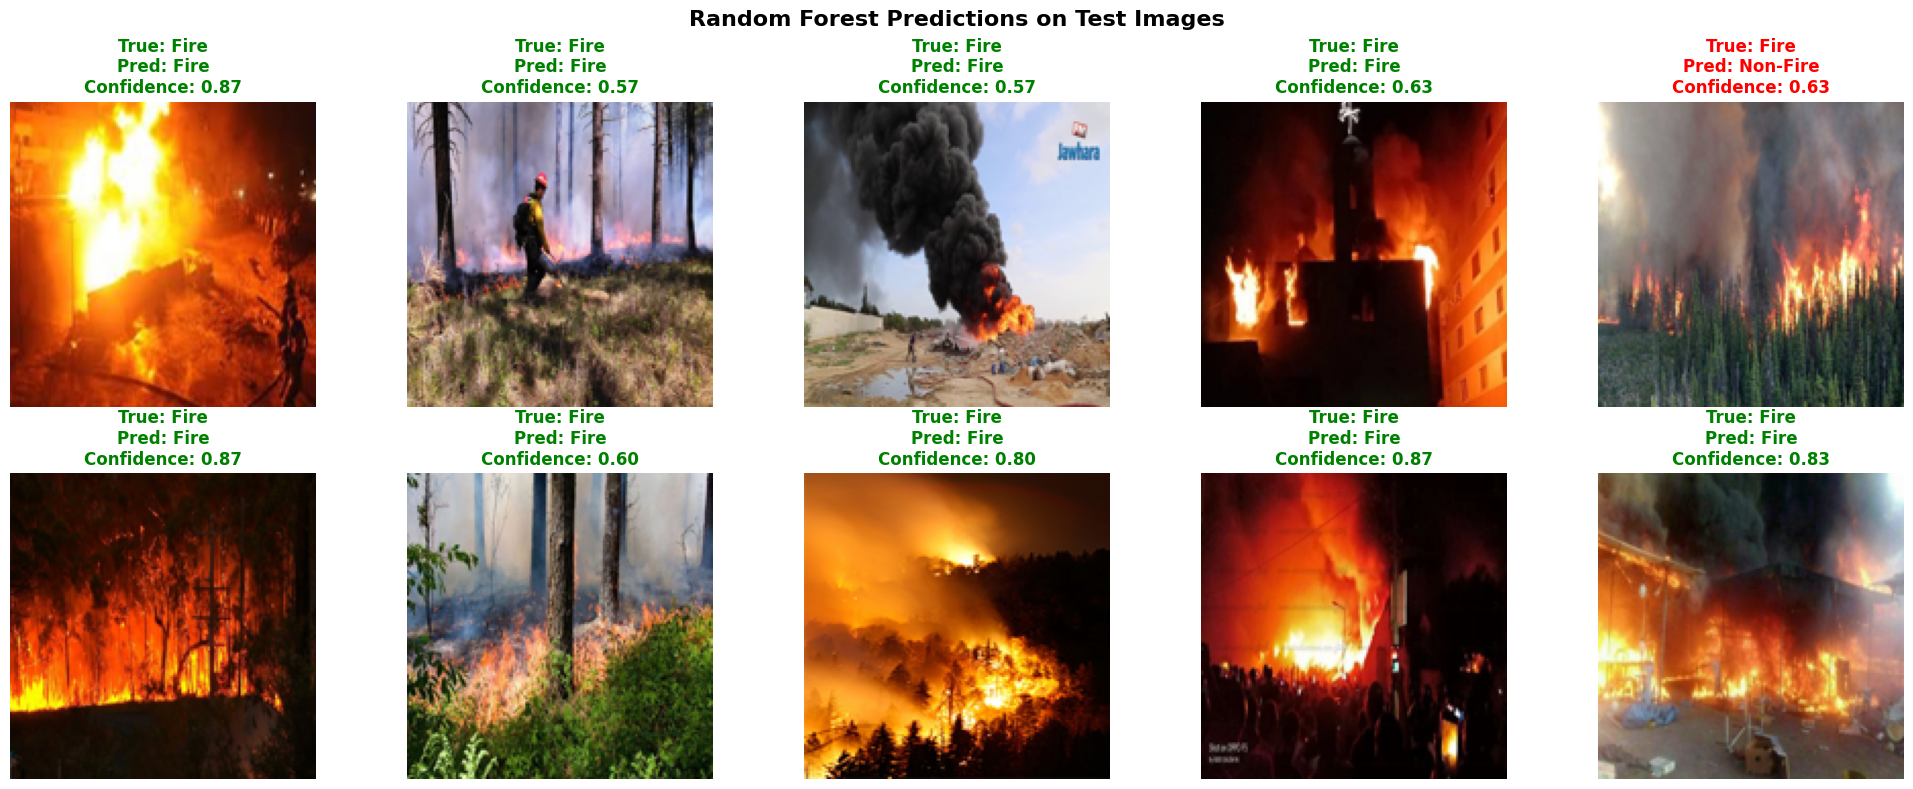

Prediction Results:
Image 1:
  Path: fire.100.png
  True: Fire
  Pred: Fire
  Status: ✓ CORRECT
  P(Fire): 0.867, P(Non-Fire): 0.133
----------------------------------------
Image 2:
  Path: fire.14.png
  True: Fire
  Pred: Fire
  Status: ✓ CORRECT
  P(Fire): 0.567, P(Non-Fire): 0.433
----------------------------------------
Image 3:
  Path: fire.16.png
  True: Fire
  Pred: Fire
  Status: ✓ CORRECT
  P(Fire): 0.567, P(Non-Fire): 0.433
----------------------------------------
Image 4:
  Path: fire.20.png
  True: Fire
  Pred: Fire
  Status: ✓ CORRECT
  P(Fire): 0.633, P(Non-Fire): 0.367
----------------------------------------
Image 5:
  Path: fire.26.png
  True: Fire
  Pred: Non-Fire
  Status: ✗ WRONG
  P(Fire): 0.367, P(Non-Fire): 0.633
----------------------------------------
Image 6:
  Path: fire.3.png
  True: Fire
  Pred: Fire
  Status: ✓ CORRECT
  P(Fire): 0.867, P(Non-Fire): 0.133
----------------------------------------
Image 7:
  Path: fire.35.png
  True: Fire
  Pred: Fire
  Sta

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Get predictions with image paths
predictions_with_images = predictions.select("path", "label", "prediction", "probability").limit(10).collect()

# Display sample predictions with actual images
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
fig.suptitle('Random Forest Predictions on Test Images', fontsize=16, fontweight='bold')

for i, row in enumerate(predictions_with_images):
    path, true_label, pred_label, probability = row
    prob_value = probability[1] if pred_label == 1 else probability[0]  # Get probability of predicted class

    # Load and display image
    img = Image.open(path)
    img = img.resize((150, 150))  # Resize for display

    ax = axes[i//5, i%5]
    ax.imshow(img)
    ax.axis('off')

    # Set title with prediction info
    title_color = 'green' if true_label == pred_label else 'red'
    ax.set_title(f'True: {"Fire" if true_label == 1 else "Non-Fire"}\n'
                f'Pred: {"Fire" if pred_label == 1 else "Non-Fire"}\n'
                f'Confidence: {prob_value:.2f}',
                color=title_color, fontweight='bold')

plt.tight_layout()
plt.savefig('/content/prediction_samples.png', dpi=300, bbox_inches='tight')
plt.show()

# Show the prediction results in a table
print("Prediction Results:")
print("=" * 80)
for i, row in enumerate(predictions_with_images):
    path, true_label, pred_label, probability = row
    status = "✓ CORRECT" if true_label == pred_label else "✗ WRONG"
    prob_fire = probability[1]  # Probability of fire class
    prob_non_fire = probability[0]  # Probability of non-fire class

    print(f"Image {i+1}:")
    print(f"  Path: {path.split('/')[-1]}")
    print(f"  True: {'Fire' if true_label == 1 else 'Non-Fire'}")
    print(f"  Pred: {'Fire' if pred_label == 1 else 'Non-Fire'}")
    print(f"  Status: {status}")
    print(f"  P(Fire): {prob_fire:.3f}, P(Non-Fire): {prob_non_fire:.3f}")
    print("-" * 40)

Training samples: 155
Test samples: 45
Training SVM model...
SVM Test Accuracy: 0.9556
SVM Precision: 0.9593
SVM Recall: 0.9556
SVM F1-Score: 0.9555


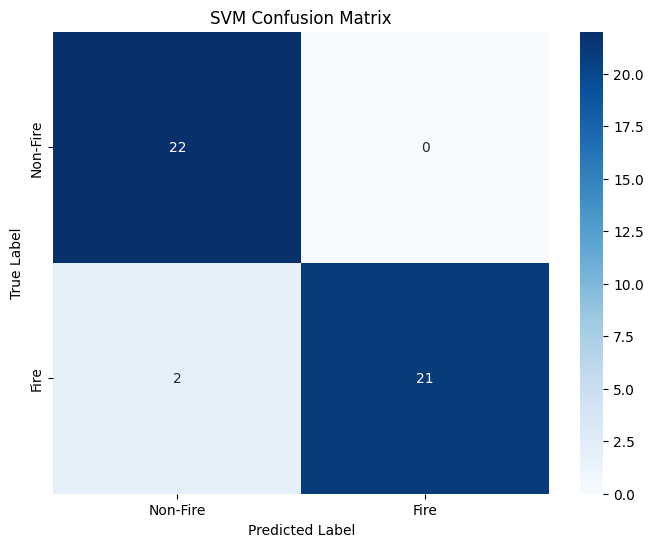

Sample predictions:
+------------------------------------------------------------------------+-----+----------+
|path                                                                    |label|prediction|
+------------------------------------------------------------------------+-----+----------+
|/content/drive/MyDrive/bdf_Dataset/fire_dataset/fire_images/fire.100.png|1    |1.0       |
|/content/drive/MyDrive/bdf_Dataset/fire_dataset/fire_images/fire.14.png |1    |1.0       |
|/content/drive/MyDrive/bdf_Dataset/fire_dataset/fire_images/fire.16.png |1    |1.0       |
|/content/drive/MyDrive/bdf_Dataset/fire_dataset/fire_images/fire.20.png |1    |1.0       |
|/content/drive/MyDrive/bdf_Dataset/fire_dataset/fire_images/fire.26.png |1    |1.0       |
|/content/drive/MyDrive/bdf_Dataset/fire_dataset/fire_images/fire.3.png  |1    |1.0       |
|/content/drive/MyDrive/bdf_Dataset/fire_dataset/fire_images/fire.35.png |1    |0.0       |
|/content/drive/MyDrive/bdf_Dataset/fire_dataset/fire_images

TypeError: min() takes 1 positional argument but 2 were given

<Figure size 1200x600 with 0 Axes>

In [ ]:
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Convert array to vector (if not already done)
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf

def array_to_vector(arr):
    return Vectors.dense(arr)

array_to_vector_udf = udf(array_to_vector, VectorUDT())
image_df = image_df.withColumn("features_vector", array_to_vector_udf(col("features")))

# Create VectorAssembler
from pyspark.ml.feature import VectorAssembler
vector_assembler = VectorAssembler(inputCols=["features_vector"], outputCol="feature_vector")

# Apply vector assembler
image_df = vector_assembler.transform(image_df)

# Split data
train_df, test_df = image_df.randomSplit([0.8, 0.2], seed=42)

print(f"Training samples: {train_df.count()}")
print(f"Test samples: {test_df.count()}")

# Train SVM model
print("Training SVM model...")
svm = LinearSVC(
    featuresCol="feature_vector",
    labelCol="label",
    maxIter=100,           # Maximum iterations
    regParam=0.01,         # Regularization parameter
    standardization=True   # Standardize features
)

svm_model = svm.fit(train_df)

# Make predictions
svm_predictions = svm_model.transform(test_df)

# Evaluate model
evaluator = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="accuracy"
)
svm_accuracy = evaluator.evaluate(svm_predictions)

print(f"SVM Test Accuracy: {svm_accuracy:.4f}")

# Additional metrics
precision = evaluator.evaluate(svm_predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(svm_predictions, {evaluator.metricName: "weightedRecall"})
f1 = evaluator.evaluate(svm_predictions, {evaluator.metricName: "f1"})

print(f"SVM Precision: {precision:.4f}")
print(f"SVM Recall: {recall:.4f}")
print(f"SVM F1-Score: {f1:.4f}")

# Confusion Matrix
pdf = svm_predictions.select("label", "prediction").toPandas()

plt.figure(figsize=(8, 6))
cm = confusion_matrix(pdf['label'], pdf['prediction'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Fire', 'Fire'],
            yticklabels=['Non-Fire', 'Fire'])
plt.title('SVM Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('/content/svm_confusion_matrix.png')
plt.show()

# Show sample predictions
print("Sample predictions:")
svm_predictions.select("path", "label", "prediction").show(10, truncate=False)

# Compare with Random Forest (if you trained it earlier)
try:
    print(f"\nComparison with Random Forest: {accuracy:.4f}")
    print(f"SVM Accuracy: {svm_accuracy:.4f}")
    if svm_accuracy > accuracy:
        print("✓ SVM performed better!")
    else:
        print("✓ Random Forest performed better!")
except:
    pass

# Get SVM coefficients (feature importance)
svm_coefficients = svm_model.coefficients.toArray()
print(f"\nSVM Model coefficients shape: {svm_coefficients.shape}")



In [ ]:
# Save SVM model
svm_model.write().overwrite().save("/content/drive/MyDrive/fire_classification_svm_model")
print("SVM model saved successfully!")

# Show misclassified examples
misclassified = svm_predictions.filter(col("label") != col("prediction"))
print(f"\nMisclassified examples: {misclassified.count()}")

if misclassified.count() > 0:
    print("Sample misclassified images:")
    misclassified.select("path", "label", "prediction").show(5, truncate=False)

SVM model saved successfully!

Misclassified examples: 2
Sample misclassified images:
+-----------------------------------------------------------------------+-----+----------+
|path                                                                   |label|prediction|
+-----------------------------------------------------------------------+-----+----------+
|/content/drive/MyDrive/bdf_Dataset/fire_dataset/fire_images/fire.35.png|1    |0.0       |
|/content/drive/MyDrive/bdf_Dataset/fire_dataset/fire_images/fire.73.png|1    |0.0       |
+-----------------------------------------------------------------------+-----+----------+



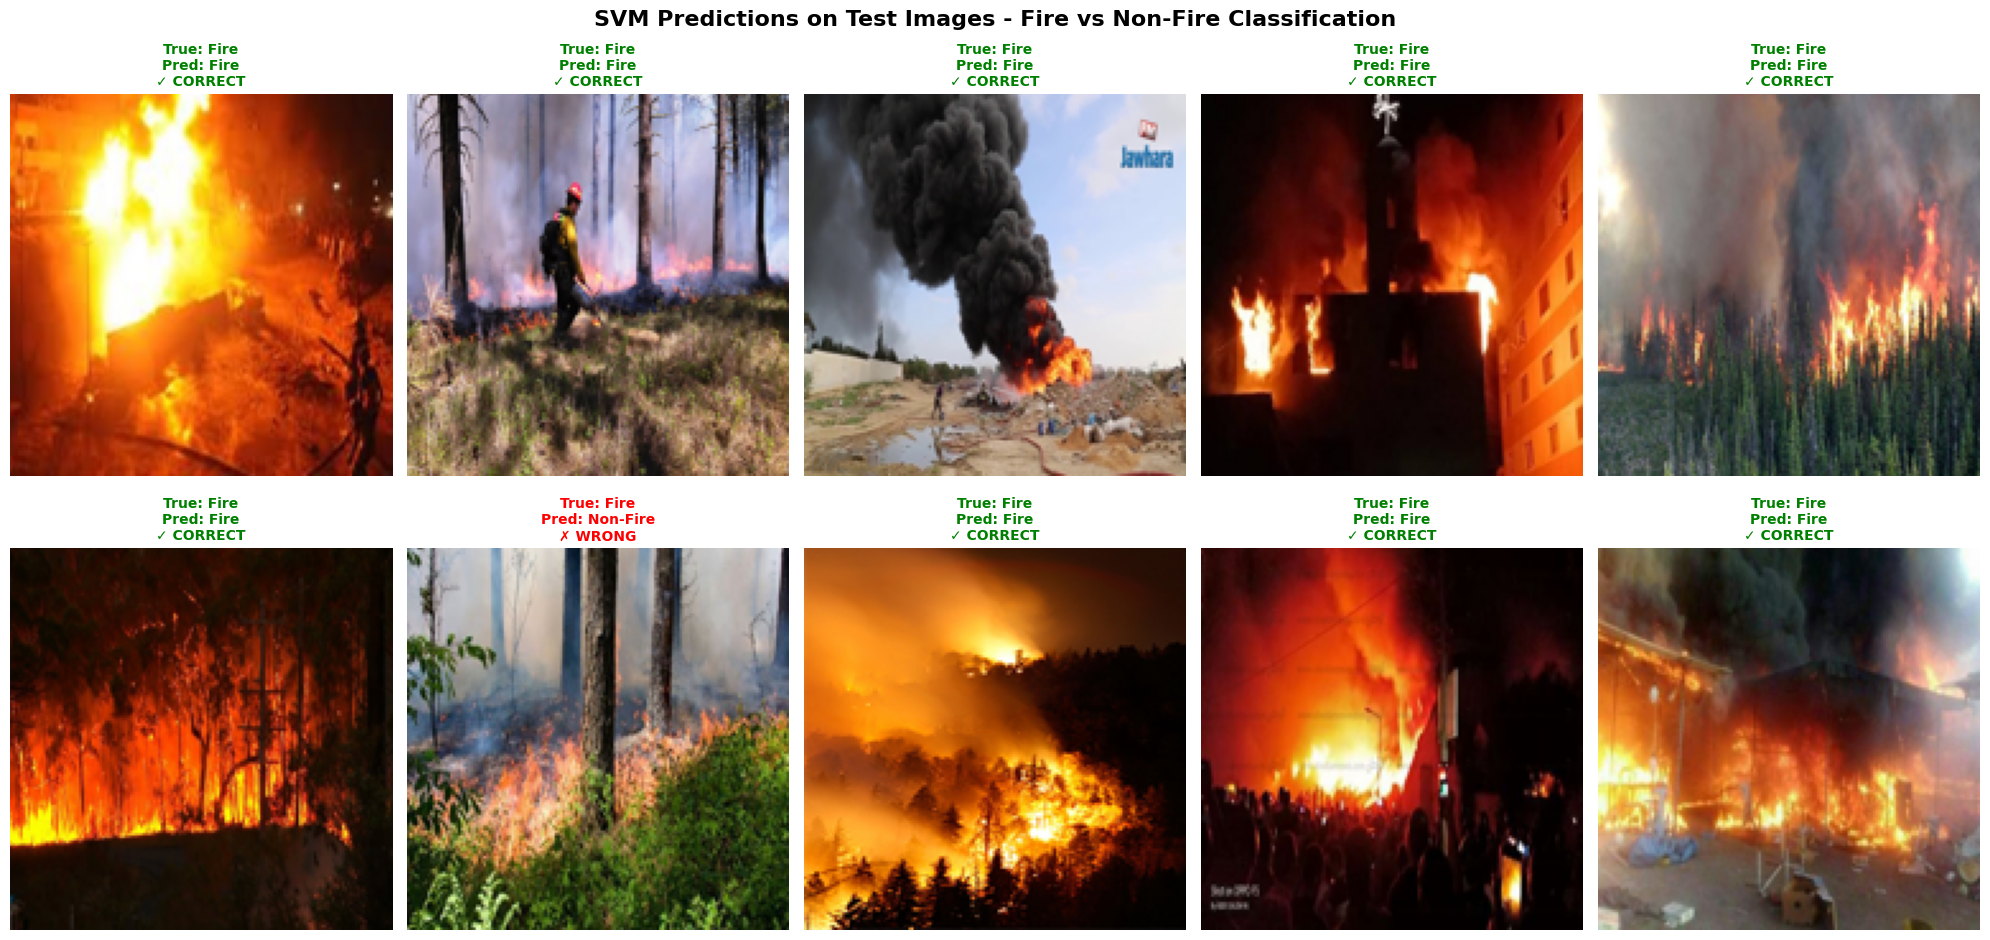

                                                  SVM PREDICTION RESULTS
Image True Label   Predicted    Status       Filename                      
1     Fire         Fire         CORRECT      fire.100.png                  
2     Fire         Fire         CORRECT      fire.14.png                   
3     Fire         Fire         CORRECT      fire.16.png                   
4     Fire         Fire         CORRECT      fire.20.png                   
5     Fire         Fire         CORRECT      fire.26.png                   
6     Fire         Fire         CORRECT      fire.3.png                    
7     Fire         Non-Fire     WRONG        fire.35.png                   
8     Fire         Fire         CORRECT      fire.40.png                   
9     Fire         Fire         CORRECT      fire.5.png                    
10    Fire         Fire         CORRECT      fire.52.png                   

OVERALL PERFORMANCE STATISTICS
Total test images: 45
Correct predictions: 43 (95.6%)
Incor

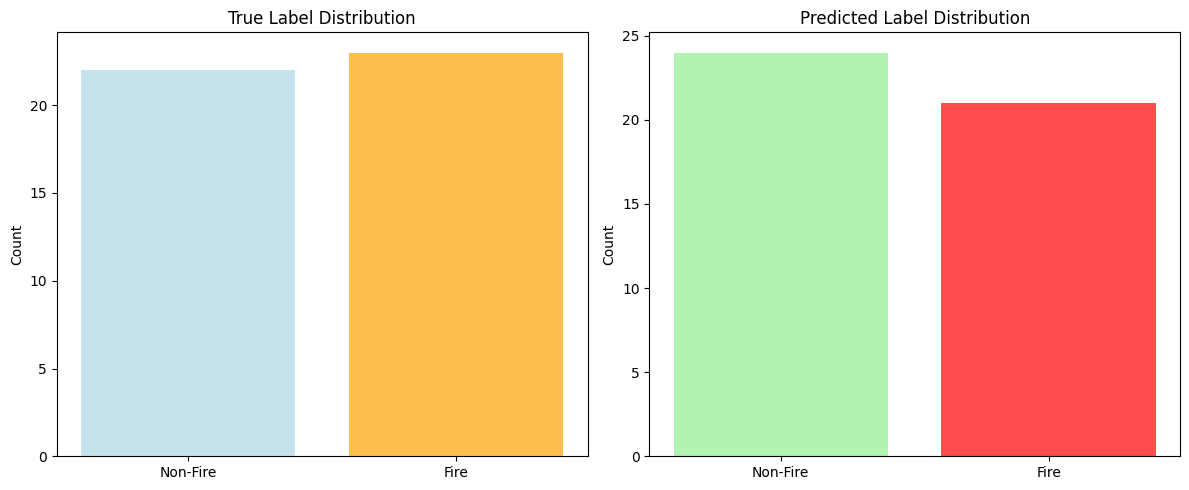

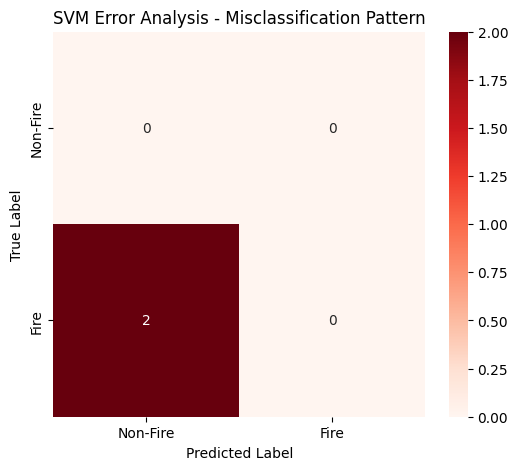


Visualization completed! Check the generated plots:
✓ svm_predictions_visualization.png - Actual images with predictions
✓ svm_label_distribution.png - Label distribution comparison
✓ svm_error_analysis.png - Error pattern analysis (if any errors)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Get predictions with image paths
svm_predictions_with_images = svm_predictions.select("path", "label", "prediction").limit(10).collect()

# Display sample predictions with actual images
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
fig.suptitle('SVM Predictions on Test Images - Fire vs Non-Fire Classification',
             fontsize=16, fontweight='bold', y=0.98)

for i, row in enumerate(svm_predictions_with_images):
    path, true_label, pred_label = row

    try:
        # Load and display image
        img = Image.open(path)
        img = img.resize((150, 150))  # Resize for display

        ax = axes[i//5, i%5]
        ax.imshow(img)
        ax.axis('off')

        # Set title with prediction info
        title_color = 'green' if true_label == pred_label else 'red'
        status = "✓ CORRECT" if true_label == pred_label else "✗ WRONG"

        ax.set_title(f'True: {"Fire" if true_label == 1 else "Non-Fire"}\n'
                    f'Pred: {"Fire" if pred_label == 1 else "Non-Fire"}\n'
                    f'{status}',
                    color=title_color, fontweight='bold', fontsize=10)

    except Exception as e:
        print(f"Error loading image {path}: {e}")
        ax = axes[i//5, i%5]
        ax.text(0.5, 0.5, f"Error loading\nimage {i+1}",
                ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f'Image {i+1}: Load Error', color='red')

plt.tight_layout()
plt.savefig('/content/svm_predictions_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

# Create a detailed results table
print(" " * 50 + "SVM PREDICTION RESULTS")
print("=" * 90)
print(f"{'Image':<5} {'True Label':<12} {'Predicted':<12} {'Status':<12} {'Filename':<30}")
print("=" * 90)

for i, row in enumerate(svm_predictions_with_images):
    path, true_label, pred_label = row
    filename = path.split('/')[-1][:28]  # Truncate long filenames
    status = "CORRECT" if true_label == pred_label else "WRONG"
    status_color = "\033[92m" if status == "CORRECT" else "\033[91m"

    print(f"{i+1:<5} {('Fire' if true_label == 1 else 'Non-Fire'):<12} "
          f"{('Fire' if pred_label == 1 else 'Non-Fire'):<12} "
          f"{status_color}{status:<12}\033[0m {filename:<30}")

# Calculate and display overall statistics
total = svm_predictions.count()
correct = svm_predictions.filter(col("label") == col("prediction")).count()
incorrect = total - correct

print("\n" + "=" * 50)
print("OVERALL PERFORMANCE STATISTICS")
print("=" * 50)
print(f"Total test images: {total}")
print(f"Correct predictions: {correct} ({correct/total*100:.1f}%)")
print(f"Incorrect predictions: {incorrect} ({incorrect/total*100:.1f}%)")
print(f"SVM Accuracy: {svm_accuracy:.4f}")

# Show misclassification analysis
misclassified = svm_predictions.filter(col("label") != col("prediction"))
if misclassified.count() > 0:
    print(f"\nMISCLASSIFICATION ANALYSIS:")
    print(f"Fire misclassified as Non-Fire: {misclassified.filter(col('label') == 1).count()}")
    print(f"Non-Fire misclassified as Fire: {misclassified.filter(col('label') == 0).count()}")

# Additional visualization: Prediction distribution
plt.figure(figsize=(12, 5))

# True label distribution
plt.subplot(1, 2, 1)
true_counts = [svm_predictions.filter(col("label") == 0).count(),
               svm_predictions.filter(col("label") == 1).count()]
plt.bar(['Non-Fire', 'Fire'], true_counts, color=['lightblue', 'orange'], alpha=0.7)
plt.title('True Label Distribution')
plt.ylabel('Count')

# Predicted label distribution
plt.subplot(1, 2, 2)
pred_counts = [svm_predictions.filter(col("prediction") == 0).count(),
               svm_predictions.filter(col("prediction") == 1).count()]
plt.bar(['Non-Fire', 'Fire'], pred_counts, color=['lightgreen', 'red'], alpha=0.7)
plt.title('Predicted Label Distribution')
plt.ylabel('Count')

plt.tight_layout()
plt.savefig('/content/svm_label_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Error pattern analysis
if misclassified.count() > 0:
    misclassified_pdf = misclassified.select("label", "prediction").toPandas()
    error_matrix = confusion_matrix(misclassified_pdf['label'], misclassified_pdf['prediction'])

    plt.figure(figsize=(6, 5))
    sns.heatmap(error_matrix, annot=True, fmt='d', cmap='Reds',
                xticklabels=['Non-Fire', 'Fire'],
                yticklabels=['Non-Fire', 'Fire'])
    plt.title('SVM Error Analysis - Misclassification Pattern')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig('/content/svm_error_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
